In [149]:
# 필수 라이브러리와 그래프 스타일 설정
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score

sns.set_theme(style="whitegrid", palette="crest")
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

In [150]:
# 1) 학습 데이터 파일 불러오기와 크기 확인
DATA_PATH = Path("../data/training/final/travel_insight.csv")

travel = pd.read_csv(DATA_PATH)

row_count, column_count = travel.shape
print(f"행(row) 수: {row_count}")
print(f"열(column) 수: {column_count}")

행(row) 수: 5103
열(column) 수: 58


In [151]:
# IS_FAILED_TRIP 비율 출력
travel['IS_FAILED_TRIP'].value_counts(normalize=True)

IS_FAILED_TRIP
0.0    0.710954
1.0    0.289046
Name: proportion, dtype: float64

In [152]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 군집화에 사용할 피처 선택 (이유 포함)
# 여행자 유형을 정의하기 위해 인구통계, 여행 행동, 지출 패턴, 만족도 등 다차원적인 특성을 고려
features_for_clustering = [
    'activity_payment_sum',
    'activity_payment_count',
    'activity_store_count',
    'activity_history_rows',
    'activity_type_unique',
    'lodging_payment_sum',
    'lodging_payment_count',
    'lodging_store_count',
    'IS_FAILED_TRIP',
    'visit_trip_days',
    'visit_move_cnt',
    'AGE_GRP',
    'EDU_NM',
    'MARR_STTS',
    'FAMILY_MEMB',
    'JOB_NM',
    'INCOME',
    'HOUSE_INCOME',
    'TRAVEL_TERM',
    'TRAVEL_NUM',
    'TRAVEL_LIKE_SIDO_1',
    # 'TRAVEL_LIKE_SGG_1',
    'TRAVEL_LIKE_SIDO_2',
    # 'TRAVEL_LIKE_SGG_2',
    'TRAVEL_LIKE_SIDO_3',
    # 'TRAVEL_LIKE_SGG_3',
    'TRAVEL_MOTIVE_1',
    'TRAVEL_MOTIVE_2',
    'TRAVEL_MOTIVE_3',
    'TRAVEL_COMPANIONS_NUM',
    'TRAVEL_STATUS_RESIDENCE_CODE',
    'TRAVEL_STATUS_DESTINATION_CODE'
]

# 피처가 데이터프레임에 존재하는지 확인
existing_features = [f for f in features_for_clustering if f in travel.columns]
cluster_data = travel[existing_features].copy()

# 결측치 처리 (중앙값으로 대체)
imputer = SimpleImputer(strategy='median')
cluster_data_imputed = imputer.fit_transform(cluster_data)

# 데이터 스케일링
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data_imputed)

print("전처리된 데이터 shape:", cluster_data_scaled.shape)

전처리된 데이터 shape: (5103, 29)


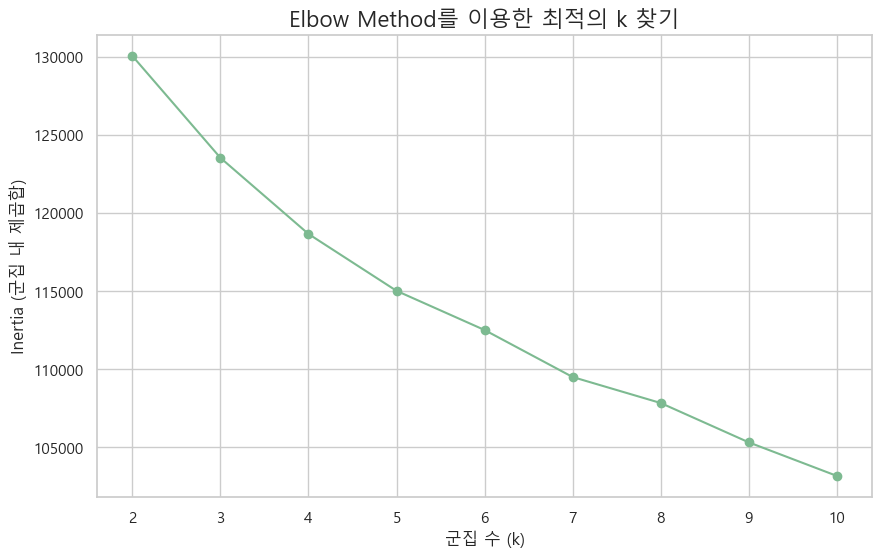

In [153]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method를 이용한 최적의 k 찾기', fontsize=16)
plt.xlabel('군집 수 (k)', fontsize=12)
plt.ylabel('Inertia (군집 내 제곱합)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

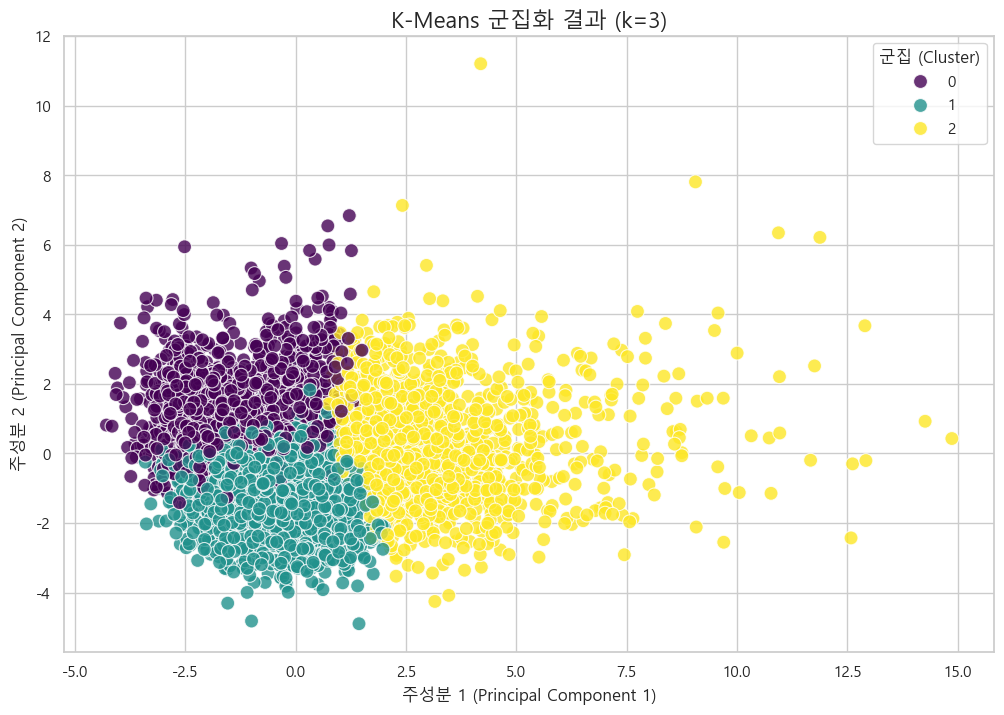

In [154]:
from sklearn.decomposition import PCA

# Elbow Method 결과에 따라 k=3로 설정 (그래프에서 팔꿈치 지점으로 가정)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(cluster_data_scaled)

# 원본 데이터에 군집 라벨 추가
travel['KMEANS_CLUSTER'] = cluster_labels

# PCA를 사용하여 2차원으로 축소
pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(cluster_data_scaled)

# 시각화를 위한 데이터프레임 생성
pca_df = pd.DataFrame(data=cluster_pca, columns=['PC1', 'PC2'])
pca_df['CLUSTER'] = cluster_labels

# 군집 결과 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='CLUSTER', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title(f'K-Means 군집화 결과 (k={optimal_k})', fontsize=16)
plt.xlabel('주성분 1 (Principal Component 1)', fontsize=12)
plt.ylabel('주성분 2 (Principal Component 2)', fontsize=12)
plt.legend(title='군집 (Cluster)')
plt.grid(True)
plt.show()

In [155]:
# PCA 결과에 대한 실루엣 스코어 출력
sil_score = silhouette_score(
    X=pca_df[['PC1', 'PC2']],
    labels=travel['KMEANS_CLUSTER']
)
sil_score

0.3120989981234025

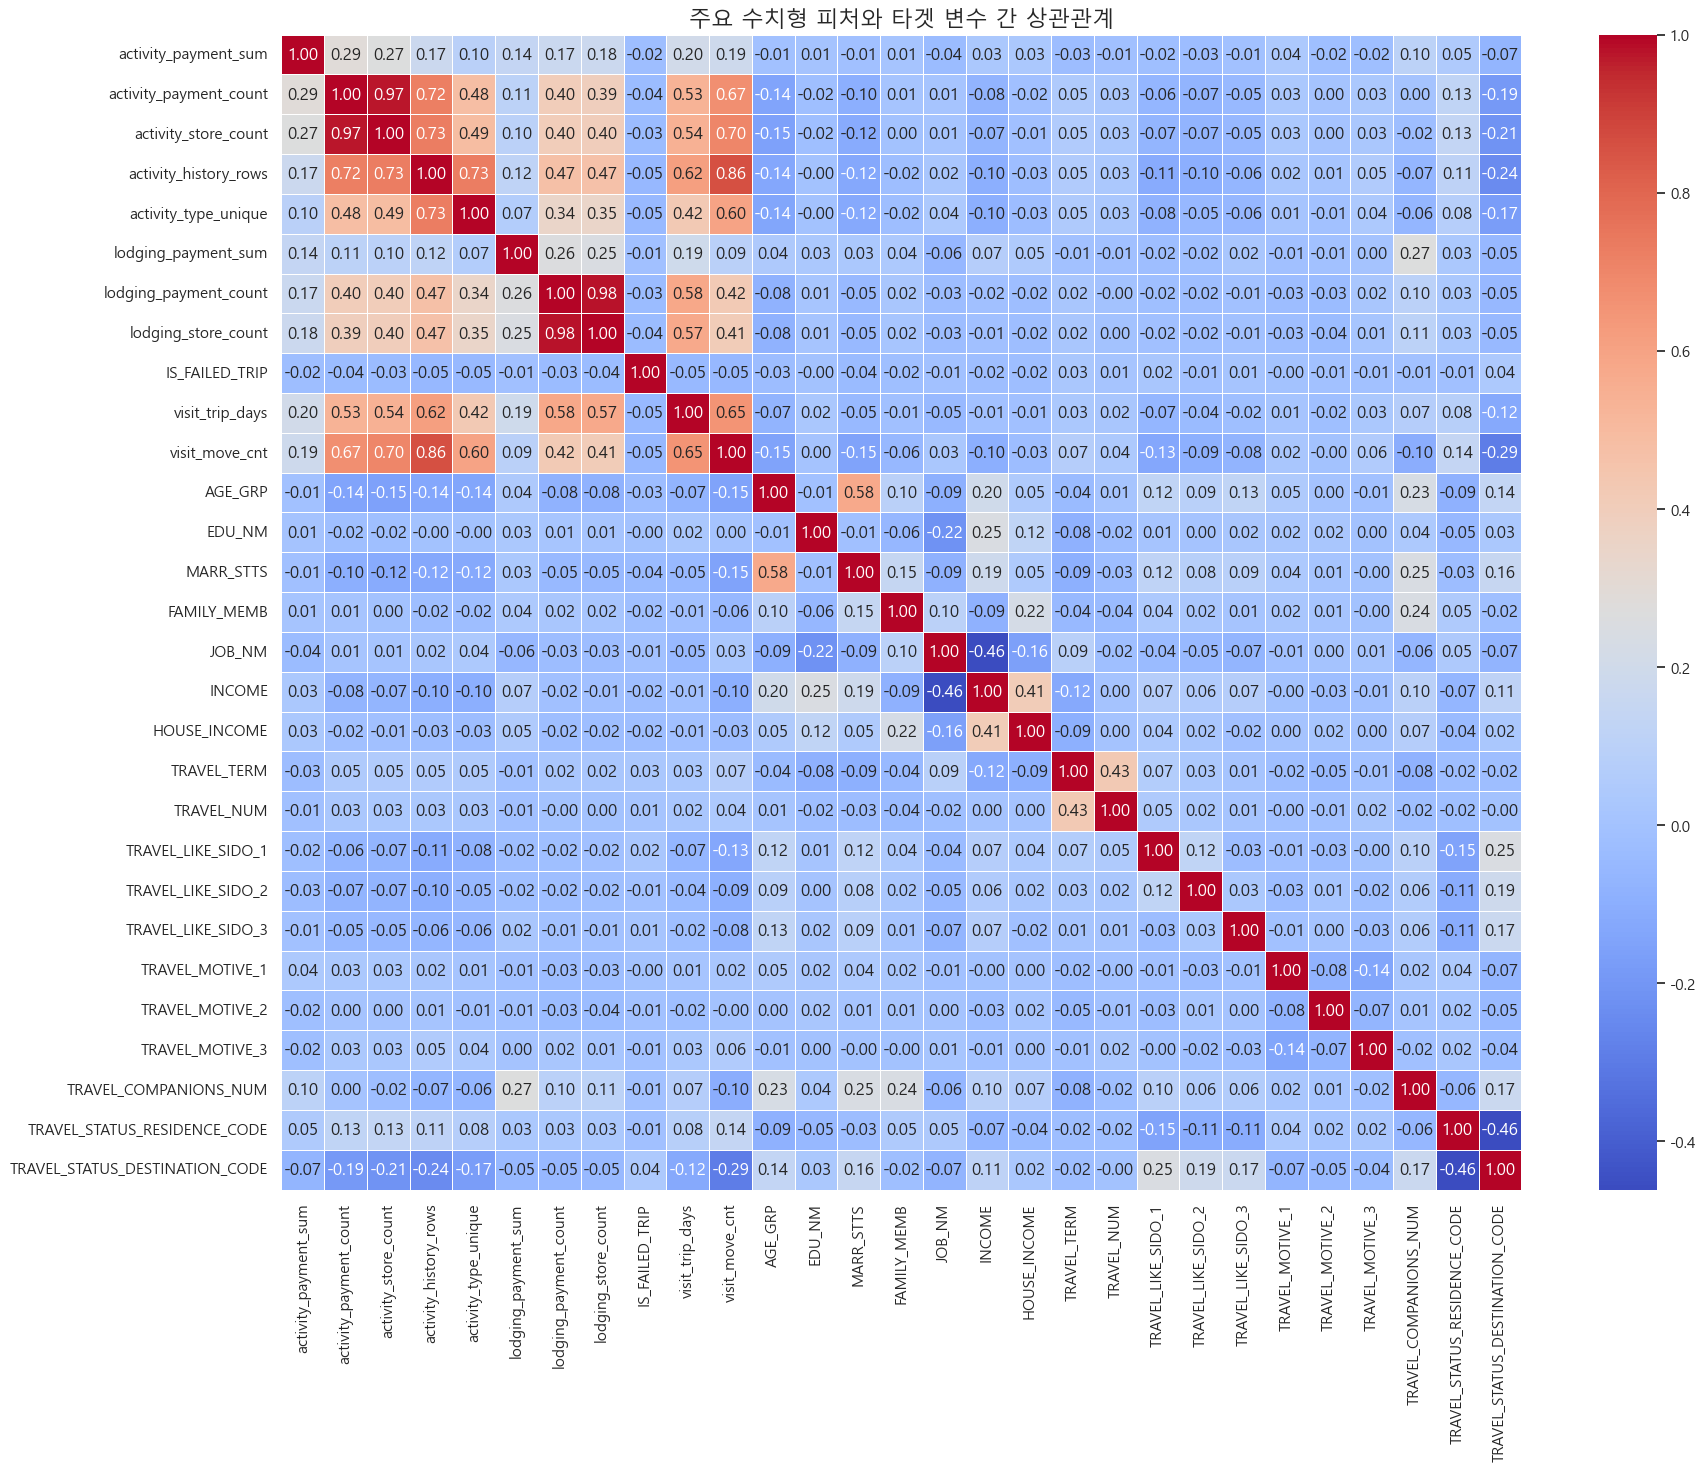

In [156]:
# 선택된 피처들 중 travel 데이터프레임에 실제 존재하는 것만 필터링
existing_features = [f for f in features_for_clustering if f in travel.columns]
corr_matrix = travel[existing_features].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('주요 수치형 피처와 타겟 변수 간 상관관계', fontsize=16)
plt.show()

In [157]:
travel[travel["TRAVEL_COMPANIONS_NUM"] >= 10]["IS_FAILED_TRIP"].value_counts()

IS_FAILED_TRIP
0.0    11
1.0     3
Name: count, dtype: int64

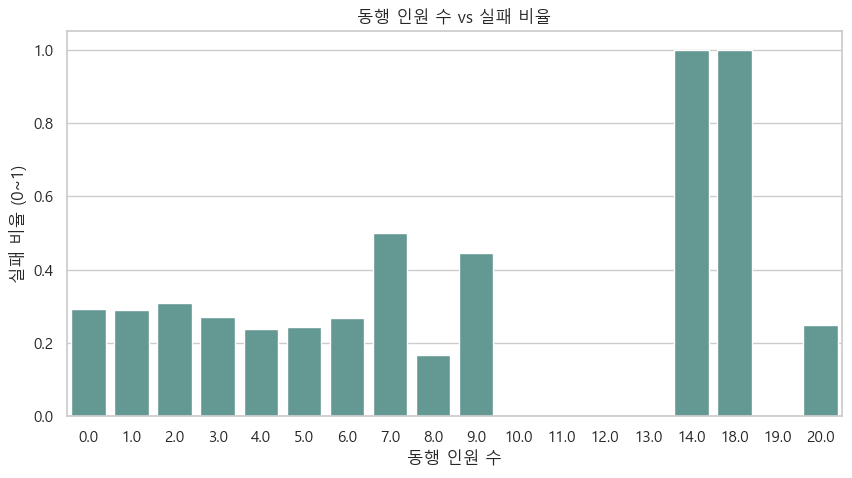

In [158]:
# 3) 동행 인원 수에 따른 실패 여행 비율
failed_rate = (
    travel.groupby("TRAVEL_COMPANIONS_NUM", dropna=False)["IS_FAILED_TRIP"]
    .mean()
    .reset_index(name="FAILED_RATE")
)

plt.figure(figsize=(10, 5))
sns.barplot(data=failed_rate, x="TRAVEL_COMPANIONS_NUM", y="FAILED_RATE", color="#5BA199")
plt.title("동행 인원 수 vs 실패 비율")
plt.xlabel("동행 인원 수")
plt.ylabel("실패 비율 (0~1)")
plt.show()